# Modelos Autoregressivo 
### Autor: Eric Kauati Saito
### Disciplina: COB862

### Identificação de sistemas
### Modelos autoregressivos (AR)
###   - ordem
###   - akaike, sbc -> inferencia?conectividade


In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft
from scipy.special import erfinv
from scipy import signal
from scipy.linalg import toeplitz
import scipy.io as spio

%matplotlib inline
from IPython.display import Image

import statsmodels as st
from statsmodels.regression.linear_model import yule_walker
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
fs = 20
t_total = 10
t = np.linspace(0, t_total, fs*t_total)

x0 = np.random.normal(size=t_total*fs)

## AutoCorrelação

In [3]:
def my_acf(x,p):
    x = x - np.mean(x)
    acf = np.zeros(((p+1),1)) 
    for lag in range (0,p+1):
        c_t = np.zeros((len(x)-(lag-1),1))
        for k in range(0, len(x)-(lag)):
            c_t[k] = x[k]*x[k+lag]
        acf[lag] = np.sum(c_t)
    acf = acf/acf[0]
    return(acf)

# Teorema de Wiener–Khinchin ou teorema de Khinchin–Kolmogorov 
def my_acf2(x,p):
    x = x - np.mean(x)
    xf = np.NaN
    xf = fft(np.concatenate((x,np.zeros(p))))
    acf = ifft(np.multiply(xf,np.conjugate(xf)))
    acf = acf[0:p+1]
    acf = acf/acf[0]
    return(acf.real)

#Reunião: Mudar para tedencioso
# Precisa ser tendencioso? Está normalizado para que o acf[0] = 1

#Reunião: Intervalo de confiança
#Reunião: Explicar H0 -> Ruido branco

def confint(x, conf = 0.95):
    critvalue = math.sqrt(2)*erfinv(conf)
    upconf = critvalue/math.sqrt(len(x))
    lowconf = -critvalue/math.sqrt(len(x))
    return(upconf, lowconf)

def my_plot_acf(x,p):
    upconf,lowconf = confint(x)
    myacf = my_acf2(x,p)
    plt.stem(myacf)
    plt.hlines(upconf,0,p, color='r', linestyles='dashed')
    plt.hlines(lowconf,0,p, color='r', linestyles='dashed')
    plt.xlabel('lags')
    plt.ylabel('ACF')
    plt.show()

### Exemplo MA(1)

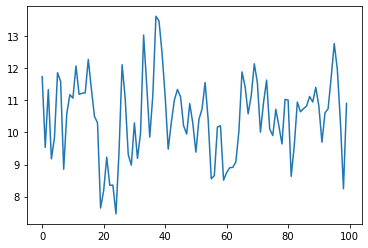

In [4]:
ls = 100
zt = np.zeros(ls)
at = np.random.normal(size = ls)
zt[0] = 10 + np.random.normal(1)

for t in range(1,ls):
    zt[t] = 10 + at[t] + at[t-1]
    
b = np.array([1, 1])
a = np.array([1])
zt2 = 10 + signal.lfilter(b, a, at)

plt.plot(zt)

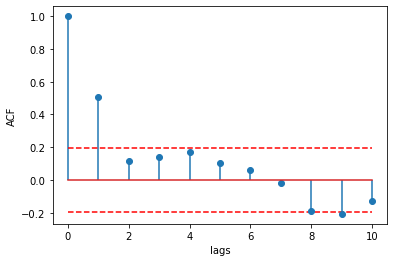

In [5]:
lag = 10
my_plot_acf(zt,lag)

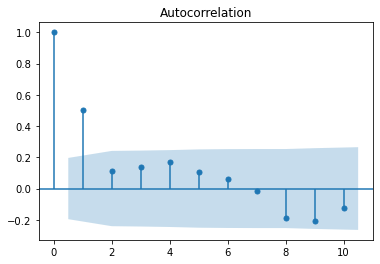

In [6]:
# IC -> Bartlett (Por que?)
plot_acf(zt,lags = lag)
plt.show()

### Exemplo AR(1)

In [40]:
b = np.array([1])
a = np.array([1, -0.8])

# Reunião:
#   polos e zeros
#   mostrar a função de transferencia
#   Y(z) = 1/(1 - 0.8(z^-1) )
#   PB

zt = signal.lfilter(b, a, x0)

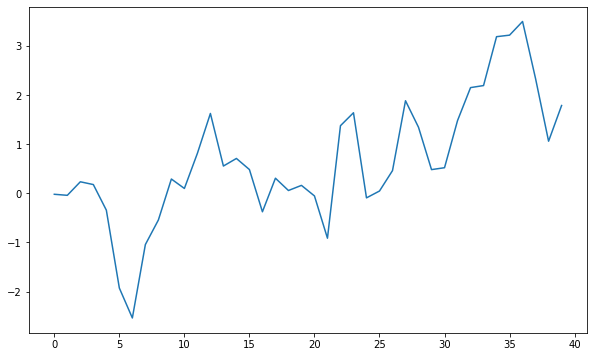

In [8]:
plt.figure(figsize=(10,6))
plt.plot(zt[:2*fs], label='x')
plt.show()

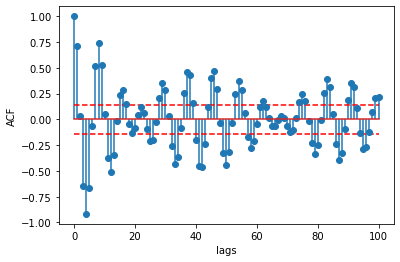

In [37]:
lag = 100
my_plot_acf(zt,lag)

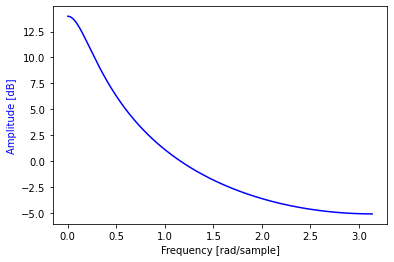

In [41]:
w, h = signal.freqz(b, a)

plt.plot(w, 20 * np.log10(abs(h)), 'b')
plt.ylabel('Amplitude [dB]', color='b')
plt.xlabel('Frequency [rad/sample]')
plt.show()

Senoidanl + decaimento exponencial

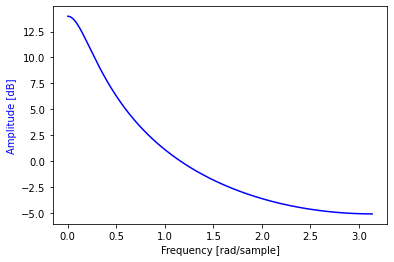

In [10]:
w, h = signal.freqz(b, a)

plt.plot(w, 20 * np.log10(abs(h)), 'b')
plt.ylabel('Amplitude [dB]', color='b')
plt.xlabel('Frequency [rad/sample]')
plt.show()

### Exemplo AR(4)

In [11]:
b = np.array([1])
a = np.array([1, -2.7607, 3.8106, -2.6535, 0.9238])

zt = signal.lfilter(b, a, x0)

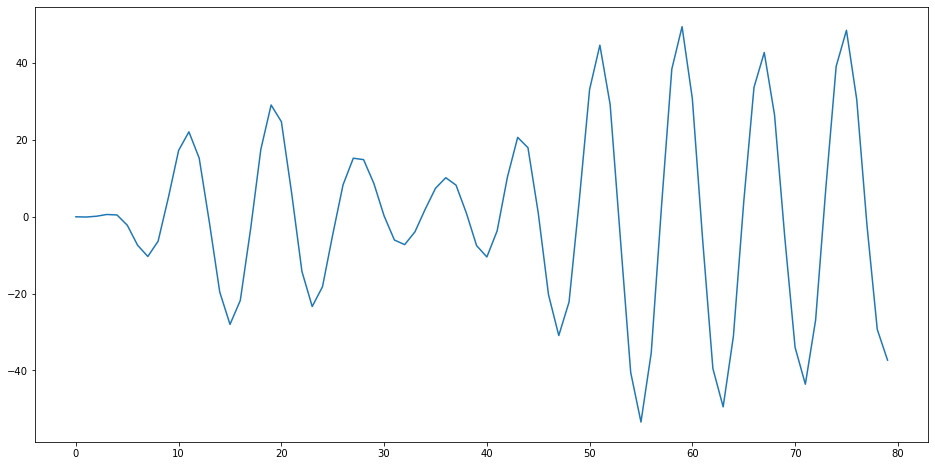

In [12]:
plt.figure(figsize=(16,8))
plt.plot(zt[:4*fs], label='x')
plt.show()

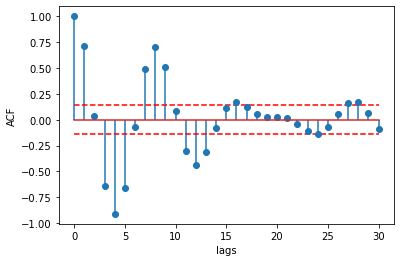

In [13]:
lag = 30
my_plot_acf(zt,lag)

"You cannot determine the appropriate order for the AR model from the sample autocorrelation sequence"

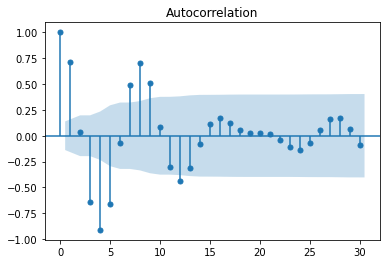

In [14]:
plot_acf(zt,lags = lag)
plt.show()

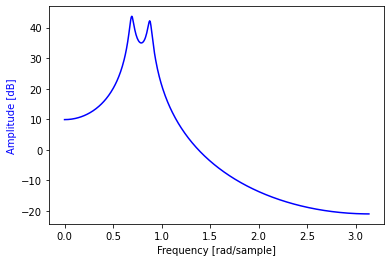

In [15]:
w, h = signal.freqz(b, a)

plt.plot(w, 20 * np.log10(abs(h)), 'b')
plt.ylabel('Amplitude [dB]', color='b')
plt.xlabel('Frequency [rad/sample]')
plt.show()

### Exemplo dados reais

::

    Number of Observations - 309 (Annual 1700 - 2008)
    Number of Variables - 1
    Variable name definitions::

        SUNACTIVITY - Number of sunspots for each year

    The data file contains a 'YEAR' variable that is not returned by load.



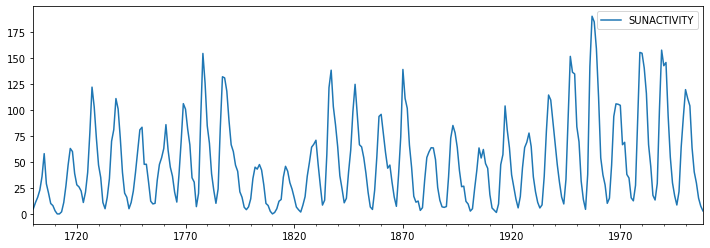

In [16]:
print(sm.datasets.sunspots.NOTE)
dta = sm.datasets.sunspots.load_pandas().data
dta.index = pd.Index(sm.tsa.datetools.dates_from_range('1700', '2008'))
del dta["YEAR"]
dta.plot(figsize=(12,4));

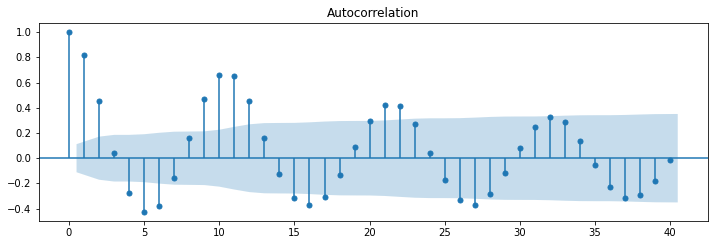

In [17]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(dta.values.squeeze(), lags=40, ax=ax1)

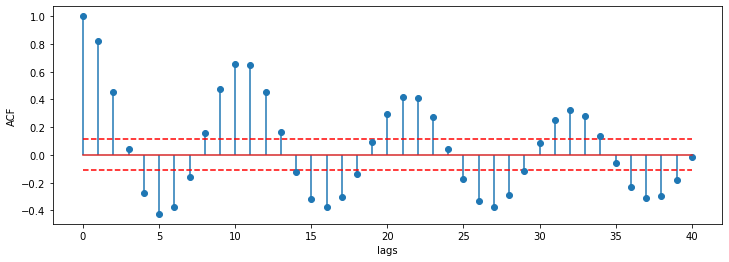

In [18]:
plt.figure(figsize=(12,4))
my_plot_acf(dta.values.squeeze(),40)

Senoide + decaimento exponencial

### Exemplo dados reais - EEG

In [19]:
ind_participante = 1

load_path = r"../../Sinais EEG/"
participante_path = "Participante " + str(ind_participante) + "/"
coleta = str(ind_participante) + "_EEG_IM_1.mat"
dados = spio.loadmat(load_path + participante_path + coleta, squeeze_me=True)

EEG_flex = dados['EEG_flex']
fs = dados['fs']
EEG = EEG_flex[0,0,:]
t = np.linspace(0.0, len(EEG)/fs, len(EEG))

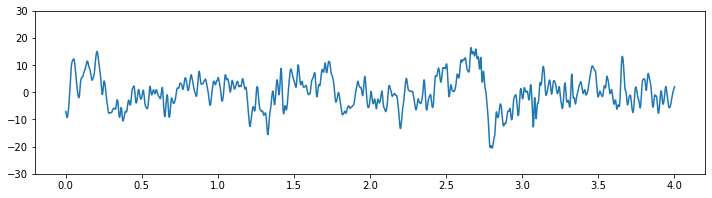

In [20]:
plt.figure(figsize=(12,3))
plt.plot(t,EEG, label='x')
plt.ylim((-30, 30)) 
plt.show()

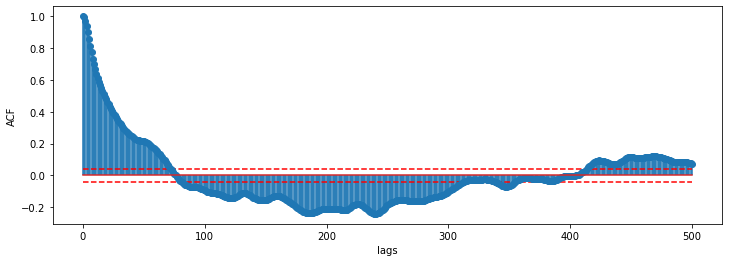

In [45]:
plt.figure(figsize=(12,4))
my_plot_acf(EEG,500)

## Estimação AR Yule-Walker

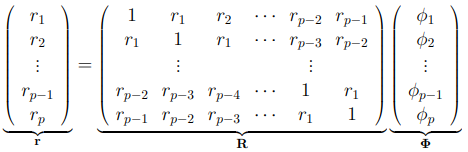

In [29]:
Image('yw.png')

In [4]:
# Matriz de autocorrelação -> Matriz Hermitiana
def my_rxx(x,p):
    myacf = my_acf2(x,p)
    R = toeplitz(myacf[:-1], np.hstack((myacf[0], np.conj(myacf[1:-1]))))
    rxx = myacf[1:]
    return(R, rxx)

# Solução por inv(R)
# Tentar: Recursão de Levinson–Durbin
def ar_yw(x,p):
    R, rxx = my_rxx(x,p)
    theta_hat = np.linalg.inv(R).dot(rxx)
    return(theta_hat)

# Função de Autocorrelação Parcial
# AR(p) -> pacf(lag>p) = 0

def my_pacf(x,maxlag):
    pacf = np.zeros((maxlag+1,1))
    pacf[0] = 1
    for lag in range (1,maxlag+1):
        theta_hat = ar_yw(x,lag)
        pacf[lag] = theta_hat[lag-1]
        
    upconf,lowconf = confint(x)
    lags_x = np.linspace(0,maxlag,maxlag+1)
    
    from matplotlib.ticker import MaxNLocator
    ax = plt.figure().gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    
    plt.stem(lags_x,pacf)
    plt.hlines(upconf,0,maxlag, color='r', linestyles='dashed')
    plt.hlines(lowconf,0,maxlag, color='r', linestyles='dashed')
    plt.xlabel('lags')
    plt.ylabel('PACF')
    plt.show()


### Exemplo AR(4)

In [6]:
fs = 20
t_total = 10

x0 = np.random.normal(size=t_total*fs)

#Reunião: É estável?
#   Analise de estabilidade, plano Z
b = np.array([1])
a = np.array([1, -2.7607, 3.8106, -2.6535, 0.9238])

zt = signal.lfilter(b, a, x0)

In [7]:
freq1 = 5
freq2 = 2
freq3 = 0.1

t = np.linspace(0, t_total, fs*t_total)

x1 = np.sin((2*np.pi*freq1)*t)
x2 = np.sin((2*np.pi*freq2)*t)
x3 = np.sin((2*np.pi*freq3)*t)
x = x1+x2+x3 + np.random.normal(size=t_total*fs)

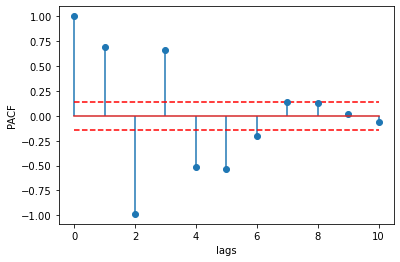

In [8]:
my_pacf(zt,10)

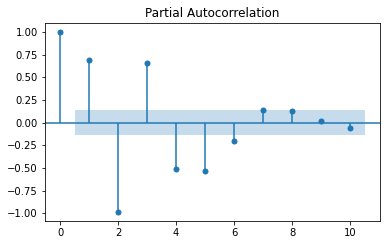

In [9]:
fig = plt.figure(figsize=(6,8))
ax1 = fig.add_subplot(211)
fig = plot_pacf(zt,lags=10, method='ywm', ax=ax1)

AR [1, -2.7607, 3.8106, -2.6535, 0.9238]

In [10]:
p = 4
theta_hat = ar_yw(zt,p)
np.concatenate([np.array([1]), -theta_hat])

array([ 1.        , -2.35287742,  2.84992285, -1.68971429,  0.51257418])

In [11]:
# Desvio?
theta, desvio = yule_walker(zt, order = p, method='mle')
np.concatenate([np.array([1]), -theta])

array([ 1.        , -2.35287742,  2.84992285, -1.68971429,  0.51257418])

In [12]:
desvio

2.2737415056204964

In [15]:
np.std(x0)

1.0266636256999848

Estimar + Erro

### Exemplo dados reais - EEG

In [30]:
ind_participante = 1

load_path = r"../../Sinais EEG/"
participante_path = "Participante " + str(ind_participante) + "/"
coleta = str(ind_participante) + "_EEG_IM_1.mat"
dados = spio.loadmat(load_path + participante_path + coleta, squeeze_me=True)

EEG_flex = dados['EEG_flex']
fs = dados['fs']
EEG = EEG_flex[0,0,:]
t = np.linspace(0.0, len(EEG)/fs, len(EEG))

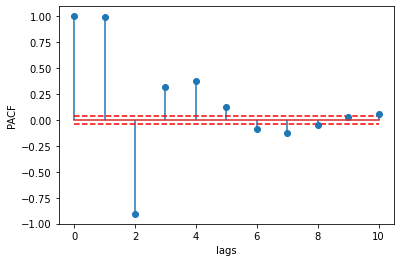

In [31]:
my_pacf(EEG,10)

In [65]:
p = 4
theta_hat = ar_yw(EEG,p)
np.concatenate([np.array([1]), -theta_hat])

# influencia no polo -> 0
# mostrar

array([ 1.        , -2.0637931 ,  0.95048918,  0.4911689 , -0.37186882])

## Critérios de seleção de modelos
### Modelos estimados por métodos de máxima verossimilhança

### AIC (Akaike), minimização do divergente de Kullback-Leibler (divergente KL) entre a distribuição real e a estimada pelo modelo
#### Ótimo em relação ao erro médio quadrático

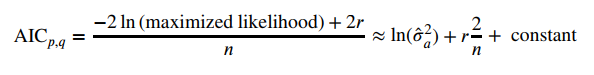

In [35]:
Image('aic.png')

### BIC (Scharz), seleção do modelo que maximiza a probabilidade a posteriori 
#### Consistente 
#### Menor número de parâmetros

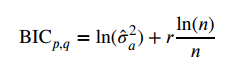

In [36]:
Image('bic.png')